In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [12]:
import models.segmentation_models_qubvel as sm
from utils.augmentation import get_preprocessing
from utils.smooth_tiled_predictions import predict_img_with_smooth_windowing

In [13]:
def visualize_ir(img, idx=None, cmap='cividis', colorbar=False, save_path=None):
    plt.imshow(img, cmap=cmap)

    if colorbar:
        plt.colorbar()
    
    if not save_path==None:
        #cv2.imwrite(os.path.join(save_path, '{}.png'.format(idx)), img)
        plt.imsave(os.path.join(save_path, '{}.png'.format(idx)), img, cmap='gray')

In [14]:
def expand_greyscale_channels(image):
    image = np.expand_dims(image, -1)
    image = image.repeat(3, axis=-1)
    return image


def crop_center_square(image, im_size=480):
    size=im_size
    height, width = image.shape[:2]
    new_width = new_height = size
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = left + new_width
    bottom = top + new_height
    cropped_image = image[top:bottom, left:right]
    return cropped_image

def label_to_pixelvalue(image):
    uniques = np.unique(image)
    
    for idx,elem in enumerate(uniques):
        mask = np.where(image == 1)
        image[mask] = 125
        mask2 = np.where(image == 2)
        image[mask2] = 255
    return image

def preprocess_prediction(image, model_preprocessing, smooth=False):
    image = expand_greyscale_channels(image)

    # create mask of zeros such that preprocessing function works
    random_mask = np.zeros(image.shape)

    sample = model_preprocessing(image=image, mask=random_mask)
    image, _ = sample['image'], sample['mask']
    image = image.astype(np.float32)

    if not smooth:
        # will add a dimension that replaces batch_size
        image = np.expand_dims(image, axis=0)
        # if smooth, function takes care of this
    
    return image

In [15]:
def patch_predict(model, image, patch_size, model_preprocessing):
    """
    Predicts on image patches and recombines masks to whole image later.
    
    This function is inspired by
    https://github.com/bnsreenu/python_for_microscopists/blob/master/206_sem_segm_large_images_using_unet_with_custom_patch_inference.py
    
    """

    # initialize mask with zeros
    segm_img = np.zeros(image.shape[:2])
    patch_num=1
    # Iterates through image in steps of patch_size, operates on patches
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            single_patch = image[i:i+patch_size, j:j+patch_size]
            single_patch_shape = single_patch.shape[:2]
            single_patch = preprocess_prediction(single_patch, model_preprocessing=model_preprocessing)
            pr_mask = model.predict(single_patch)
            # removes batch dimension and channel dimension by replacing the latter with class with maximum probability value
            pr_mask_processed = np.argmax(pr_mask.squeeze(), axis=2)
            # make mask values visible
            fin = label_to_pixelvalue(pr_mask_processed)
            # recombine to complete image
            segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(fin, single_patch_shape[::-1])
            print("Finished processing patch number ", patch_num, " at position ", i,j)
            patch_num+=1

    return segm_img

In [16]:
def smooth_patch_predict(model, image, patch_size, model_preprocessing, smooth):
    """
    https://github.com/bnsreenu/python_for_microscopists/tree/master/229_smooth_predictions_by_blending_patches
    
    How this should work: 
    Motivation: There might be high error on the predictions made near the outside of the window,
    predictions are just concatenated.

    - uses 2D interpolation between overlapping patches when doing final predictions
    - split image into patches, using a 5D np array (ordering in space can require two extra
    dimensions?)
    - reshape those patches to 4D with along a single batch size to be passed into the prediction function
    - put predictions together back into 5D array to be merged with a spline interpolation to a regular 3D array

    - first, use roation and mirroring so as to make the NN view the image under several different angles
    - this is averaged out and thus reduces variance in the predictions
    - predictions are blended together using interpolation with a simple second order spline window function:
    weighting pixels when merging patches together
    - amount of overlap between merged windows can be changed

    """

    input_image = preprocess_prediction(image, model_preprocessing=model_preprocessing, smooth=smooth)
    print(input_image.shape)
    predictions_smooth = predict_img_with_smooth_windowing(
        input_image,
        window_size=patch_size,
        subdivisions = 4, # minimal amount of overlap - must be an even number
        nb_classes = 3,
        pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
        )
    )

    final_prediction = np.argmax(predictions_smooth.squeeze(), axis=2)
    final_prediction = label_to_pixelvalue(final_prediction)

    return final_prediction

In [17]:
def predict(img, im_size, weights, backbone='resnet34', train_transfer='imagenet', smooth=False, save_path=None):
    
    #if not im_size==480:
    #    img = crop_center_square(img, 256)
    
    BACKBONE = backbone
    TRAIN_TRANSFER = train_transfer
    WEIGHTS = weights

    prepro = get_preprocessing(sm.get_preprocessing(BACKBONE))

    model = sm.Unet(BACKBONE, input_shape=(im_size, im_size, 3), classes=3, activation='softmax', encoder_weights=TRAIN_TRANSFER)
    model.load_weights(weights)

    if smooth:
        segmented_image = smooth_patch_predict(model, img, im_size, model_preprocessing=prepro, smooth=True)
    else:
        segmented_image = patch_predict(model, img, im_size, model_preprocessing=prepro)
    #segmented_image = segmented_image.squeeze()
    visualize_ir(segmented_image)
    cv2.imwrite(save_path, segmented_image)

In [19]:
# prediction images (cropped and grayscale)
flight9_dir = 'E:/polar/code/data/evaluation/qualitative/flight9/'
flight16_dir = 'E:/polar/code/data/evaluation/qualitative/flight16/'

weights_final = 'weights/best_modelfinal_run100.h5'
weights_long = 'weights/best_modelfinal_run200.h5'
weights_short = 'weights/best_modelfinal_run62.h5'
weights_64 = 'weights/best_modelpatch_size_64_foldn3.h5'
weights_run_sharpen_200 = 'weights/best_modelfinal_runsharpen200.h5'
weights500 = 'weights/best_modelfinal_runsharpen500.h5'
weights_sharpenblurr = None

1/1 [==============================] - 4s 4s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0


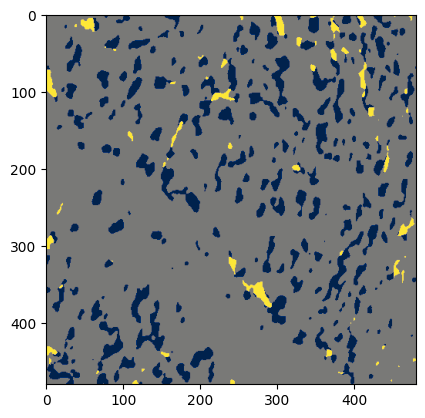

In [9]:
for idx, file in enumerate(os.listdir(flight9_dir)):
    img = cv2.imread(os.path.join(flight9_dir, file), 0)
    predict(img, 480, weights500, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/default/pred_9/{}.png'.format(idx))

1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0


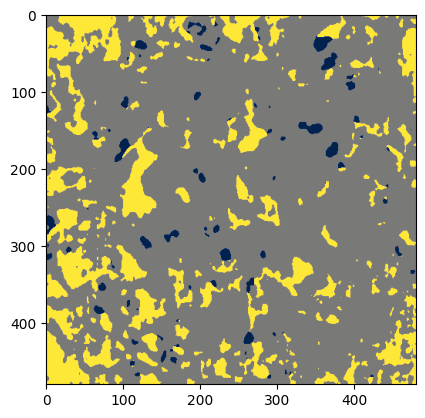

In [10]:
for idx, file in enumerate(os.listdir(flight16_dir)):
    img = cv2.imread(os.path.join(flight16_dir, file), 0)
    predict(img, 480, weights500, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/default/pred_16/{}.png'.format(idx))

1/1 [==============================] - 1s 1s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 0s 84ms/step
Finished processing patch number  2  at position  0 64
1/1 [==============================] - 0s 104ms/step
Finished processing patch number  3  at position  0 128
1/1 [==============================] - 0s 67ms/step
Finished processing patch number  4  at position  0 192
1/1 [==============================] - 0s 93ms/step
Finished processing patch number  5  at position  0 256
1/1 [==============================] - 0s 79ms/step
Finished processing patch number  6  at position  0 320
1/1 [==============================] - 0s 70ms/step
Finished processing patch number  7  at position  0 384


InvalidArgumentError: Graph execution error:

Detected at node 'model_33/decoder_stage0_concat/concat' defined at (most recent call last):
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\marle\AppData\Local\Temp\ipykernel_18752\304417073.py", line 4, in <module>
      predict(img, 64, weights_64, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/thesis_figures/64_unsmooth', smooth=False)
    File "C:\Users\marle\AppData\Local\Temp\ipykernel_18752\689146248.py", line 18, in predict
      segmented_image = patch_predict(model, img, im_size, model_preprocessing=prepro)
    File "C:\Users\marle\AppData\Local\Temp\ipykernel_18752\4120482031.py", line 19, in patch_predict
      pr_mask = model.predict(single_patch)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\layers\merging\base_merge.py", line 196, in call
      return self._merge_function(inputs)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\layers\merging\concatenate.py", line 134, in _merge_function
      return backend.concatenate(inputs, axis=self.axis)
    File "c:\Users\marle\miniconda3\envs\sea_ice\lib\site-packages\keras\backend.py", line 3572, in concatenate
      return tf.concat([to_dense(x) for x in tensors], axis)
Node: 'model_33/decoder_stage0_concat/concat'
ConcatOp : Dimension 2 in both shapes must be equal: shape[0] = [1,4,4,512] vs. shape[1] = [1,4,2,256]
	 [[{{node model_33/decoder_stage0_concat/concat}}]] [Op:__inference_predict_function_74935]

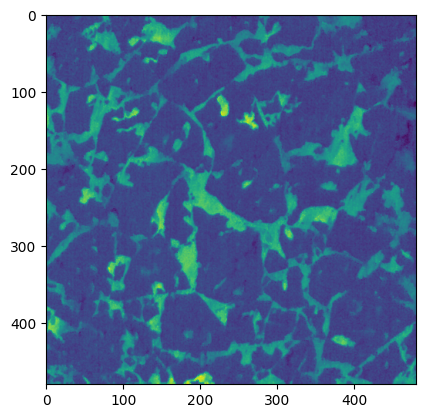

In [24]:
# to exemplify border effects
img = cv2.imread(os.path.join(flight9_dir, '1.png'), 0)
plt.imshow(img)
predict(img, 64, weights_64, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/thesis_figures/64_unsmooth', smooth=False)
predict(img, 64, weights_64, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/thesis_figures/64_smooth', smooth=True)

1/1 [==============================] - 5s 5s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 6s 6s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0


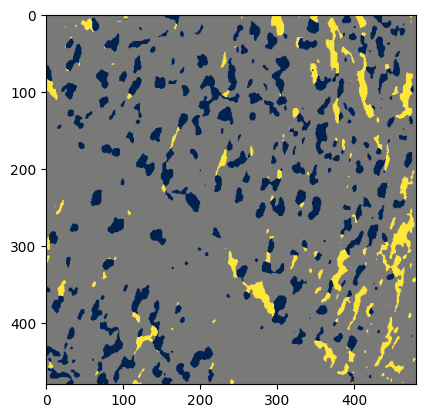

In [9]:
for idx, file in enumerate(os.listdir(flight9_dir)):
    img = cv2.imread(os.path.join(flight9_dir, file), 0)
    predict(img, 480, weights_long, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/long/pred_9/{}.png'.format(idx))

1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 4s 4s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 5s 5s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 4s 4s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 4s 4s/step
Finished processing patch number  1  at position  0 0


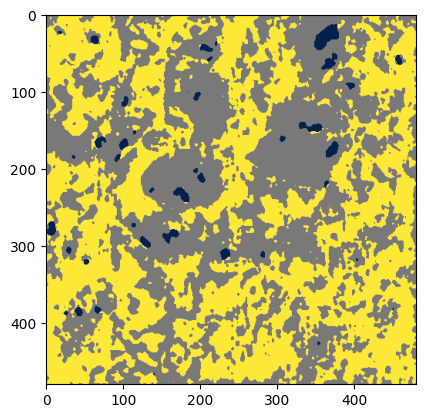

In [10]:
for idx, file in enumerate(os.listdir(flight16_dir)):
    img = cv2.imread(os.path.join(flight16_dir, file), 0)
    predict(img, 480, weights_long, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/long/pred_16/{}.png'.format(idx))

1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 4s 4s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 4s 4s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0


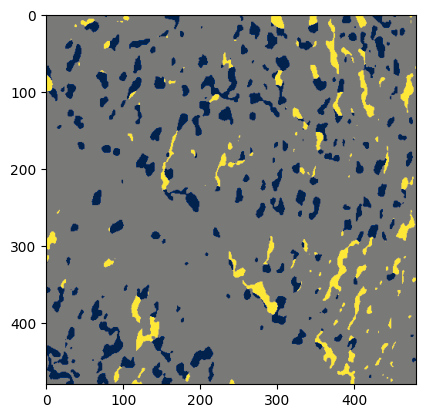

In [11]:
for idx, file in enumerate(os.listdir(flight9_dir)):
    img = cv2.imread(os.path.join(flight9_dir, file), 0)
    predict(img, 480, weights_short, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/short/pred_9/{}.png'.format(idx))

1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0


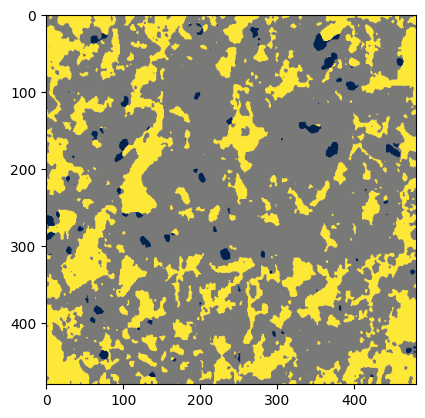

In [12]:
for idx, file in enumerate(os.listdir(flight16_dir)):
    img = cv2.imread(os.path.join(flight16_dir, file), 0)
    predict(img, 480, weights_short, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/short/pred_16/{}.png'.format(idx))

(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 22s 158ms/step


 12%|█▎        | 1/8 [00:24<02:54, 24.93s/it]

125/125 [==============================] - 30s 238ms/step


 25%|██▌       | 2/8 [00:56<02:52, 28.67s/it]

125/125 [==============================] - 21s 167ms/step


 38%|███▊      | 3/8 [01:39<02:56, 35.21s/it]

125/125 [==============================] - 19s 151ms/step


 50%|█████     | 4/8 [02:01<02:00, 30.02s/it]

125/125 [==============================] - 18s 146ms/step


 62%|██████▎   | 5/8 [02:20<01:18, 26.29s/it]

125/125 [==============================] - 18s 146ms/step


 75%|███████▌  | 6/8 [02:40<00:48, 24.06s/it]

125/125 [==============================] - 18s 144ms/step


 88%|████████▊ | 7/8 [03:00<00:22, 22.57s/it]

125/125 [==============================] - 18s 146ms/step


100%|██████████| 8/8 [03:19<00:00, 25.00s/it]


(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 20s 148ms/step


 12%|█▎        | 1/8 [00:21<02:30, 21.50s/it]

125/125 [==============================] - 19s 149ms/step


 25%|██▌       | 2/8 [00:41<02:04, 20.79s/it]

125/125 [==============================] - 19s 150ms/step


 38%|███▊      | 3/8 [01:02<01:43, 20.69s/it]

125/125 [==============================] - 19s 149ms/step


 50%|█████     | 4/8 [01:22<01:22, 20.61s/it]

125/125 [==============================] - 19s 148ms/step


 62%|██████▎   | 5/8 [01:43<01:01, 20.48s/it]

125/125 [==============================] - 19s 148ms/step


 75%|███████▌  | 6/8 [02:03<00:40, 20.48s/it]

125/125 [==============================] - 20s 159ms/step


 88%|████████▊ | 7/8 [02:25<00:20, 21.00s/it]

125/125 [==============================] - 21s 166ms/step


100%|██████████| 8/8 [02:48<00:00, 21.03s/it]


(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 21s 155ms/step


 12%|█▎        | 1/8 [00:22<02:39, 22.84s/it]

125/125 [==============================] - 24s 191ms/step


 25%|██▌       | 2/8 [00:48<02:27, 24.55s/it]

125/125 [==============================] - 26s 210ms/step


 38%|███▊      | 3/8 [01:17<02:11, 26.32s/it]

125/125 [==============================] - 22s 177ms/step


 50%|█████     | 4/8 [01:41<01:41, 25.42s/it]

125/125 [==============================] - 20s 160ms/step


 62%|██████▎   | 5/8 [02:02<01:12, 24.06s/it]

125/125 [==============================] - 20s 157ms/step


 75%|███████▌  | 6/8 [02:24<00:46, 23.20s/it]

125/125 [==============================] - 21s 166ms/step


 88%|████████▊ | 7/8 [02:46<00:22, 22.96s/it]

125/125 [==============================] - 20s 157ms/step


100%|██████████| 8/8 [03:08<00:00, 23.51s/it]


(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 23s 167ms/step


 12%|█▎        | 1/8 [00:24<02:50, 24.36s/it]

125/125 [==============================] - 20s 163ms/step


 25%|██▌       | 2/8 [00:46<02:17, 22.93s/it]

125/125 [==============================] - 18s 147ms/step


 38%|███▊      | 3/8 [01:06<01:47, 21.55s/it]

125/125 [==============================] - 19s 152ms/step


 50%|█████     | 4/8 [01:26<01:24, 21.14s/it]

125/125 [==============================] - 20s 159ms/step


 62%|██████▎   | 5/8 [01:48<01:03, 21.22s/it]

125/125 [==============================] - 20s 158ms/step


 75%|███████▌  | 6/8 [02:09<00:42, 21.28s/it]

125/125 [==============================] - 20s 159ms/step


 88%|████████▊ | 7/8 [02:30<00:21, 21.31s/it]

125/125 [==============================] - 21s 165ms/step


100%|██████████| 8/8 [02:53<00:00, 21.64s/it]


(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 22s 163ms/step


 12%|█▎        | 1/8 [00:23<02:43, 23.30s/it]

125/125 [==============================] - 20s 162ms/step


 25%|██▌       | 2/8 [00:45<02:14, 22.37s/it]

125/125 [==============================] - 20s 162ms/step


 38%|███▊      | 3/8 [01:06<01:50, 22.13s/it]

125/125 [==============================] - 21s 166ms/step


 50%|█████     | 4/8 [01:29<01:29, 22.26s/it]

125/125 [==============================] - 21s 164ms/step


 62%|██████▎   | 5/8 [01:51<01:06, 22.26s/it]

125/125 [==============================] - 21s 165ms/step


 75%|███████▌  | 6/8 [02:13<00:44, 22.26s/it]

125/125 [==============================] - 21s 166ms/step


 88%|████████▊ | 7/8 [02:36<00:22, 22.34s/it]

125/125 [==============================] - 20s 162ms/step


100%|██████████| 8/8 [02:58<00:00, 22.27s/it]


(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 22s 165ms/step


 12%|█▎        | 1/8 [00:23<02:43, 23.31s/it]

125/125 [==============================] - 21s 165ms/step


 25%|██▌       | 2/8 [00:45<02:15, 22.65s/it]

125/125 [==============================] - 20s 163ms/step


 38%|███▊      | 3/8 [01:07<01:52, 22.42s/it]

125/125 [==============================] - 20s 162ms/step


 50%|█████     | 4/8 [01:29<01:28, 22.16s/it]

125/125 [==============================] - 21s 166ms/step


 62%|██████▎   | 5/8 [01:51<01:06, 22.21s/it]

125/125 [==============================] - 21s 169ms/step


 75%|███████▌  | 6/8 [02:14<00:44, 22.41s/it]

125/125 [==============================] - 21s 169ms/step


 88%|████████▊ | 7/8 [02:37<00:22, 22.46s/it]

125/125 [==============================] - 20s 164ms/step


100%|██████████| 8/8 [02:59<00:00, 22.39s/it]


(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 21s 160ms/step


 12%|█▎        | 1/8 [00:22<02:38, 22.69s/it]

125/125 [==============================] - 20s 164ms/step


 25%|██▌       | 2/8 [00:44<02:13, 22.25s/it]

125/125 [==============================] - 22s 173ms/step


 38%|███▊      | 3/8 [01:07<01:53, 22.70s/it]

125/125 [==============================] - 24s 193ms/step


 50%|█████     | 4/8 [01:33<01:35, 23.99s/it]

125/125 [==============================] - 23s 184ms/step


 62%|██████▎   | 5/8 [01:58<01:12, 24.32s/it]

125/125 [==============================] - 22s 179ms/step


 75%|███████▌  | 6/8 [02:22<00:48, 24.26s/it]

125/125 [==============================] - 22s 173ms/step


 88%|████████▊ | 7/8 [03:05<00:30, 30.26s/it]

125/125 [==============================] - 21s 168ms/step


100%|██████████| 8/8 [03:48<00:00, 28.50s/it]


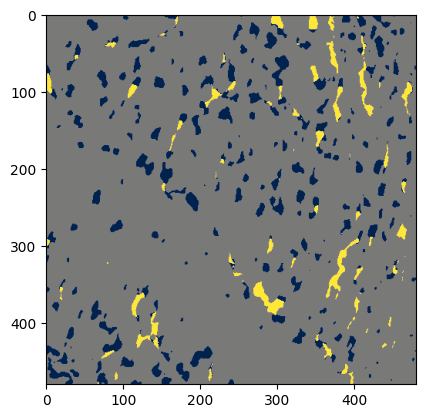

In [9]:
for idx, file in enumerate(os.listdir(flight9_dir)):
    img = cv2.imread(os.path.join(flight9_dir, file), 0)
    predict(img, 32, weights_32, smooth=True, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/32_smooth/pred_9/{}.png'.format(idx))

(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 22s 162ms/step


 12%|█▎        | 1/8 [00:23<02:44, 23.49s/it]

125/125 [==============================] - 20s 164ms/step


 25%|██▌       | 2/8 [00:45<02:15, 22.60s/it]

125/125 [==============================] - 21s 166ms/step


 38%|███▊      | 3/8 [01:07<01:52, 22.49s/it]

125/125 [==============================] - 21s 170ms/step


 50%|█████     | 4/8 [01:30<01:30, 22.67s/it]

125/125 [==============================] - 21s 168ms/step


 62%|██████▎   | 5/8 [01:53<01:07, 22.64s/it]

125/125 [==============================] - 21s 168ms/step


 75%|███████▌  | 6/8 [02:15<00:45, 22.60s/it]

125/125 [==============================] - 22s 173ms/step


 88%|████████▊ | 7/8 [02:39<00:22, 22.83s/it]

125/125 [==============================] - 21s 167ms/step


100%|██████████| 8/8 [03:01<00:00, 22.71s/it]


(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 22s 168ms/step


 12%|█▎        | 1/8 [00:24<02:48, 24.13s/it]

125/125 [==============================] - 22s 175ms/step


 25%|██▌       | 2/8 [00:47<02:22, 23.73s/it]

125/125 [==============================] - 21s 167ms/step


 38%|███▊      | 3/8 [01:30<02:41, 32.31s/it]

125/125 [==============================] - 21s 170ms/step


 50%|█████     | 4/8 [01:52<01:54, 28.58s/it]

125/125 [==============================] - 21s 169ms/step


 62%|██████▎   | 5/8 [02:15<01:19, 26.51s/it]

125/125 [==============================] - 21s 168ms/step


 75%|███████▌  | 6/8 [02:38<00:50, 25.18s/it]

125/125 [==============================] - 22s 173ms/step


 88%|████████▊ | 7/8 [03:01<00:24, 24.52s/it]

125/125 [==============================] - 21s 171ms/step


100%|██████████| 8/8 [03:24<00:00, 25.58s/it]


(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 21s 162ms/step


 12%|█▎        | 1/8 [00:23<02:41, 23.11s/it]

125/125 [==============================] - 20s 157ms/step


 25%|██▌       | 2/8 [00:44<02:11, 21.97s/it]

125/125 [==============================] - 20s 156ms/step


 38%|███▊      | 3/8 [01:05<01:47, 21.59s/it]

125/125 [==============================] - 20s 158ms/step


 50%|█████     | 4/8 [01:26<01:26, 21.57s/it]

125/125 [==============================] - 21s 164ms/step


 62%|██████▎   | 5/8 [01:49<01:05, 21.92s/it]

125/125 [==============================] - 21s 166ms/step


 75%|███████▌  | 6/8 [02:11<00:44, 22.10s/it]

125/125 [==============================] - 19s 154ms/step


 88%|████████▊ | 7/8 [02:32<00:21, 21.67s/it]

125/125 [==============================] - 19s 155ms/step


100%|██████████| 8/8 [02:53<00:00, 21.70s/it]


(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 21s 158ms/step


 12%|█▎        | 1/8 [00:22<02:38, 22.62s/it]

125/125 [==============================] - 19s 155ms/step


 25%|██▌       | 2/8 [00:43<02:09, 21.64s/it]

125/125 [==============================] - 19s 156ms/step


 38%|███▊      | 3/8 [01:04<01:46, 21.31s/it]

125/125 [==============================] - 21s 165ms/step


 50%|█████     | 4/8 [01:26<01:26, 21.69s/it]

125/125 [==============================] - 20s 159ms/step


 62%|██████▎   | 5/8 [01:48<01:05, 21.69s/it]

125/125 [==============================] - 20s 161ms/step


 75%|███████▌  | 6/8 [02:10<00:43, 21.67s/it]

125/125 [==============================] - 19s 155ms/step


 88%|████████▊ | 7/8 [02:30<00:21, 21.39s/it]

125/125 [==============================] - 19s 155ms/step


100%|██████████| 8/8 [02:51<00:00, 21.48s/it]


(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 21s 160ms/step


 12%|█▎        | 1/8 [00:22<02:40, 22.93s/it]

125/125 [==============================] - 22s 175ms/step


 25%|██▌       | 2/8 [00:46<02:19, 23.28s/it]

125/125 [==============================] - 21s 169ms/step


 38%|███▊      | 3/8 [01:28<02:40, 32.03s/it]

125/125 [==============================] - 21s 171ms/step


 50%|█████     | 4/8 [01:51<01:53, 28.38s/it]

125/125 [==============================] - 21s 165ms/step


 62%|██████▎   | 5/8 [02:34<01:40, 33.44s/it]

125/125 [==============================] - 21s 166ms/step


 75%|███████▌  | 6/8 [02:56<00:59, 29.65s/it]

125/125 [==============================] - 26s 205ms/step


 88%|████████▊ | 7/8 [03:23<00:28, 28.84s/it]

125/125 [==============================] - 23s 186ms/step


100%|██████████| 8/8 [04:06<00:00, 30.79s/it]


(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 22s 166ms/step


 12%|█▎        | 1/8 [00:23<02:45, 23.59s/it]

125/125 [==============================] - 20s 164ms/step


 25%|██▌       | 2/8 [00:45<02:16, 22.71s/it]

125/125 [==============================] - 22s 174ms/step


 38%|███▊      | 3/8 [01:09<01:54, 22.99s/it]

125/125 [==============================] - 22s 172ms/step


 50%|█████     | 4/8 [01:32<01:32, 23.10s/it]

125/125 [==============================] - 22s 175ms/step


 62%|██████▎   | 5/8 [01:55<01:09, 23.26s/it]

125/125 [==============================] - 21s 172ms/step


 75%|███████▌  | 6/8 [02:18<00:46, 23.20s/it]

125/125 [==============================] - 21s 171ms/step


 88%|████████▊ | 7/8 [02:42<00:23, 23.18s/it]

125/125 [==============================] - 21s 165ms/step


100%|██████████| 8/8 [03:04<00:00, 23.05s/it]


(480, 480, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

125/125 [==============================] - 21s 160ms/step


 12%|█▎        | 1/8 [00:22<02:40, 22.89s/it]

125/125 [==============================] - 20s 158ms/step


 25%|██▌       | 2/8 [00:44<02:11, 21.95s/it]

125/125 [==============================] - 20s 157ms/step


 38%|███▊      | 3/8 [01:05<01:47, 21.57s/it]

125/125 [==============================] - 20s 158ms/step


 50%|█████     | 4/8 [01:26<01:25, 21.45s/it]

125/125 [==============================] - 20s 156ms/step


 62%|██████▎   | 5/8 [01:47<01:03, 21.33s/it]

125/125 [==============================] - 21s 167ms/step


 75%|███████▌  | 6/8 [02:10<00:43, 21.71s/it]

125/125 [==============================] - 21s 169ms/step


 88%|████████▊ | 7/8 [02:32<00:22, 22.07s/it]

125/125 [==============================] - 22s 174ms/step


100%|██████████| 8/8 [02:56<00:00, 22.05s/it]


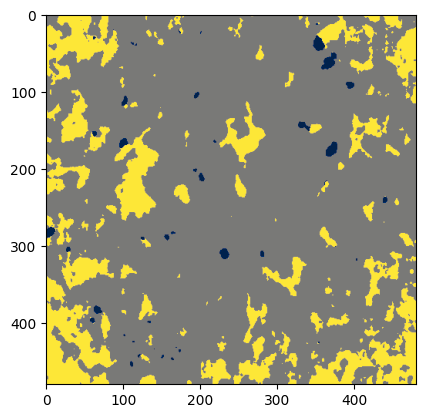

In [10]:
for idx, file in enumerate(os.listdir(flight16_dir)):
    img = cv2.imread(os.path.join(flight16_dir, file), 0)
    predict(img, 32, weights_32, smooth=True, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/32_smooth/pred_16/{}.png'.format(idx))

1/1 [==============================] - 1s 1s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 0s 56ms/step
Finished processing patch number  2  at position  0 32
1/1 [==============================] - 0s 57ms/step
Finished processing patch number  3  at position  0 64
1/1 [==============================] - 0s 61ms/step
Finished processing patch number  4  at position  0 96
1/1 [==============================] - 0s 58ms/step
Finished processing patch number  5  at position  0 128
1/1 [==============================] - 0s 50ms/step
Finished processing patch number  6  at position  0 160
1/1 [==============================] - 0s 55ms/step
Finished processing patch number  7  at position  0 192
1/1 [==============================] - 0s 55ms/step
Finished processing patch number  8  at position  0 224
1/1 [==============================] - 0s 52ms/step
Finished processing patch number  9  at position  0 256
1/1 [==============================

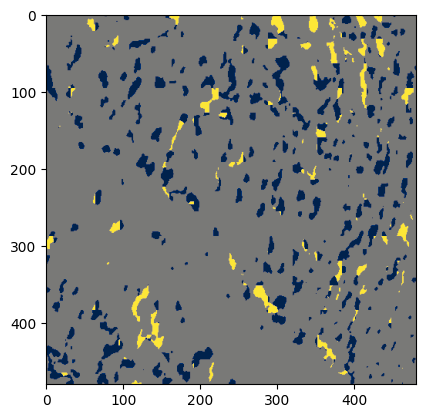

In [11]:
for idx, file in enumerate(os.listdir(flight9_dir)):
    img = cv2.imread(os.path.join(flight9_dir, file), 0)
    predict(img, 32, weights_32, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/32_unsmooth/pred_9/{}.png'.format(idx))

1/1 [==============================] - 1s 1s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 0s 56ms/step
Finished processing patch number  2  at position  0 32
1/1 [==============================] - 0s 126ms/step
Finished processing patch number  3  at position  0 64
1/1 [==============================] - 0s 66ms/step
Finished processing patch number  4  at position  0 96
1/1 [==============================] - 0s 62ms/step
Finished processing patch number  5  at position  0 128
1/1 [==============================] - 0s 71ms/step
Finished processing patch number  6  at position  0 160
1/1 [==============================] - 0s 60ms/step
Finished processing patch number  7  at position  0 192
1/1 [==============================] - 0s 65ms/step
Finished processing patch number  8  at position  0 224
1/1 [==============================] - 0s 63ms/step
Finished processing patch number  9  at position  0 256
1/1 [=============================

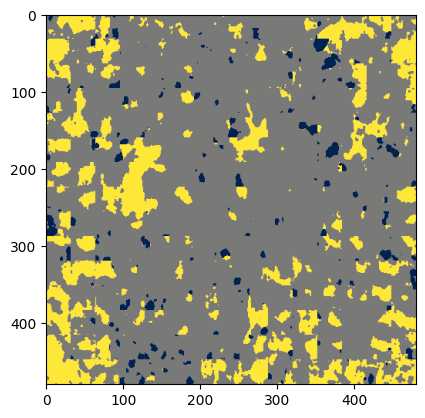

In [12]:
for idx, file in enumerate(os.listdir(flight16_dir)):
    img = cv2.imread(os.path.join(flight16_dir, file), 0)
    predict(img, 32, weights_32, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/32_unsmooth/pred_16/{}.png'.format(idx))

In [ ]:
for idx, file in enumerate(os.listdir(flight9_dir)):
    img = cv2.imread(os.path.join(flight9_dir, file), 0)
    predict(img, 480, weights_sharpenblurr, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/blur/pred_9/{}.png'.format(idx))

In [ ]:
for idx, file in enumerate(os.listdir(flight16_dir)):
    img = cv2.imread(os.path.join(flight16_dir, file), 0)
    predict(img, 480, weights_sharpenblurr, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/blur/pred_16/{}.png'.format(idx))